In [61]:
import random
import math

import numpy as np
from numba import njit, prange

import pandas as pd

from matplotlib import pyplot as plt

In [62]:
def gen_ring_sample(c: tuple, r1: float, r2: float, n: int, label:str):
    data = []

    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(r1, r2)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return {
        'features': np.array(data),
        'label': label
    }

def gen_circle_smaple(c: tuple, r: float, n: int, label: str):
    data = []
    
    for i in range(n):
        angle = random.uniform(0, 2*math.pi)
        dist = random.uniform(0, r)

        data.append([c[0]+dist*math.cos(angle), c[1]+dist*math.sin(angle)])
    
    return {
        'features': np.array(data),
        'label': label
    }

In [317]:
def F(x: np.ndarray) -> float:
    return np.clip(x,-1, 1)
    # return np.tanh(x)


def dF(x: np.ndarray) -> float:
    return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    # return 1-np.square(np.tanh(x))


@njit()
def F_jit(x: np.ndarray) -> np.ndarray:
    return np.clip(x,-1, 1)
    # return np.tanh(x)


@njit()
def dF_jit(x: np.ndarray) -> np.ndarray:
    return np.array([0 if xi <= -1 or xi >= 1 else 1 for xi in x])
    # return 1-np.square(np.tanh(x))


@njit()
def grads(xBatch:np.ndarray, w:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dw = np.zeros(w.shape)
    db = np.zeros(b.shape)
    
    u = np.zeros((w.shape[0], w.shape[2]))
    y = np.zeros(w.shape[1])
    
    for i in prange(xBatch.shape[0]):
        u*=0
        y*=0
            
        for j in prange(w.shape[0]):
            u[j] = xBatch[i] @ w[j] + b[j]
            y += F_jit(u[j]) @ w[j].T
        
        dEdy = 2/(w.shape[1]*w.shape[0]) * (y-xBatch[i])        

        for j in prange(w.shape[0]):
            dw[j] += (dEdy @ w[j]) * dF_jit(u[j]) * np.atleast_2d(xBatch[i]).T
            db[j] += (dEdy @ w[j]) * dF_jit(u[j])
            
    return dw, db


class MultiRBM:
    def __init__(self, nIn: int, nH: int, nL:int) -> None:
        self.nIn = nIn
        self.nH = nH
        self.nL = nL
        
        self.w: np.ndarray = np.random.uniform(-1, 1, (nL, nIn, nH))
        self.b: np.ndarray = np.zeros((nL, nH))


    def predict(self, x:np.ndarray) -> np.ndarray:
        y = np.zeros(self.nIn)
        
        for i in range(self.w.shape[0]):
            y += F(x @ self.w[i] + self.b[i]) @ self.w[i].T
            
        return y

    def train(self, xTrain: np.ndarray, lr, batch_size, max_iter) -> None:
        n = xTrain.shape[0]
        
        for k in range(max_iter):
            idxs = np.random.choice(a=np.arange(n), size=batch_size, replace=False)
            
            dw, db = grads(xTrain[idxs], self.w, self.b)
            
            self.w -= lr*dw
            self.b -= lr*db
        

    def loss(self, x: np.ndarray) -> float:
        Xpred = np.array([self.predict(xi) for xi in x])
        d = 1/self.nIn * np.sum(np.square(x-Xpred), axis=1)
        return 1/x.shape[0] * np.sum(d)

In [64]:
sample1 = gen_circle_smaple((0,0), 1, 300, 'A')

data = [sample1]

In [65]:
df = pd.DataFrame(columns=['x1', 'x2', 'label'])

for sample in data:
    for feature in sample['features']:
        df.loc[len(df.index)] = [*feature, sample['label']]

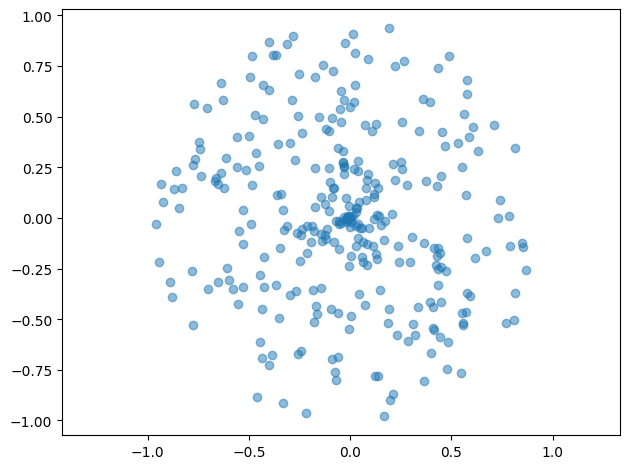

In [66]:
for label in df['label'].unique():
    plt.scatter(df[df['label'] == label]['x1'], df[df['label'] == label]['x2'], alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

In [266]:
test_frac = 0.8

p = np.random.permutation(df.index.size)

test_size = int(p.size*test_frac)
train_size = int(p.size*(1-test_frac))

idx_test = p[0:test_size]
idx_train = p[test_size:p.size]

xTest = np.array(df.iloc[idx_test][['x1', 'x2']])

xTrain = np.array(df.iloc[idx_train][['x1', 'x2']])

In [337]:
nIn = 2
nH = 2
nL = 8

lr = 1e-2
batch_size = 15
max_iter = 1000

model = MultiRBM(nIn, nH, nL)

print('untrained loss: {0:.6f}'.format(model.loss(xTest)))

model.train(xTrain, lr, batch_size, max_iter)

print('trained loss: {0:.6f}'.format(model.loss(xTest)))

untrained loss: 2.781029
trained loss: 0.000002


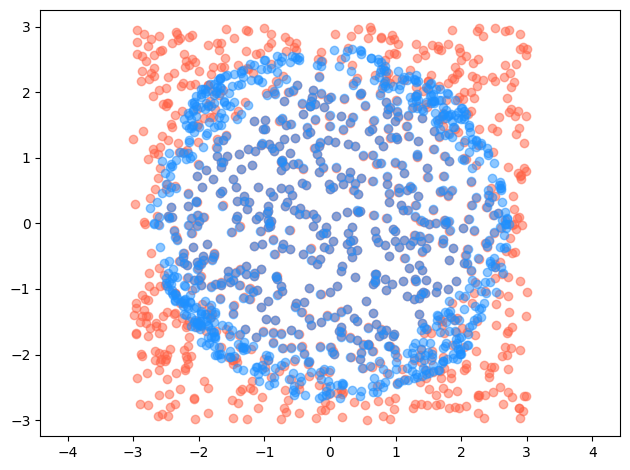

In [338]:
x = np.random.uniform(-3, 3, (1000, 2))

u = np.array([model.predict(xi) for xi in x])

plt.scatter(x[:,0], x[:,1], c='tomato', alpha=0.5)
plt.scatter(u[:,0], u[:,1], c='dodgerblue', alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()

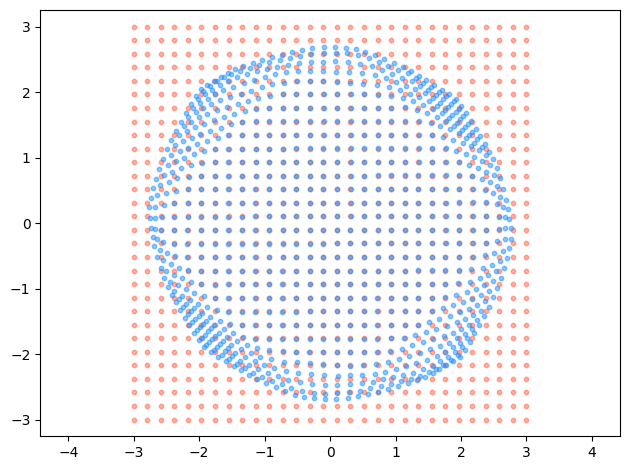

In [340]:
x = np.linspace(-3, 3, 30)
y = np.linspace(-3, 3, 30)

xx, yy = np.meshgrid(x, y)

pts = np.vstack([xx.ravel(), yy.ravel()]).T

u = np.array([model.predict(p) for p in pts])

plt.scatter(pts[:,0], pts[:,1], c='tomato', s=10, alpha=0.5)
plt.scatter(u[:,0], u[:,1], c='dodgerblue', s=10, alpha=0.5)

plt.axis('equal')
plt.tight_layout()
plt.show()